Sentiment Analysis with Huggingface transformer and Tensorflow

Dataset : https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/

Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [1]:
# Dataset will be loaded using kaggle api

In [2]:
!pip install kaggle

In [3]:
import kaggle

In [4]:
import kaggle # after saving the kaggle.json in required path

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
api = KaggleApi()

In [7]:
api.authenticate()

In [8]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                             'test.tsv.zip', path='./')
                             

test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# trying by creating a new token
# it works after creating new token..

In [10]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                             'train.tsv.zip', path='./')

train.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
# here we have zip files , so extract it

In [12]:
import zipfile

In [13]:
with zipfile.ZipFile('./test.tsv.zip','r') as zipref:
    zipref.extractall('./')

In [14]:
with zipfile.ZipFile('./train.tsv.zip','r') as zipref:
    zipref.extractall('./')

### This completes data download step

## Data Preprocessing Stage

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('train.tsv',sep='\t')

In [17]:
df.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [18]:
# here there are duplicates
# remove duplicates by keeping the first instance

# running below code will drop the duplicates
# but since the dataset is small so removing it will underfit

#df.drop_duplicates(subset=['SentenceId'],keep='first')

In [19]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:>

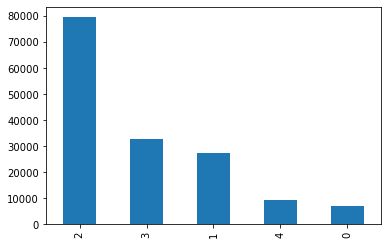

In [20]:
df['Sentiment'].value_counts().plot(kind='bar')

#### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [21]:
# tokenize its so that we can get token id and attention mask values for
# hugging face transformer

In [22]:
# we need tensors in form numpy arrays
# give seq length and num of samples

seq_len = 512
num_samples = len(df)

seq_len , num_samples

(512, 156060)

### Import BERT 

In [23]:
from transformers import BertTokenizer

In [24]:
!pip install transformers

In [25]:
from transformers import BertTokenizer

In [26]:
!pip install tensorflow

In [27]:
from transformers import BertTokenizer

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

### Information about bert-base-cased : 
https://huggingface.co/bert-base-cased

In [29]:
tokens = tokenizer(df['Phrase'].to_list(),
                  max_length=seq_len,
                  truncation=True,
                  padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np')

In [30]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [31]:
tokens['input_ids']
# this will show all different types of tokens
# ex: SEP , CLS , UNK 

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [32]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [33]:
# save these arrays as binary files

import numpy as np

with open('movie-ids.npy','w') as f:
    np.save(f,tokens['input_ids'])
with open('movie-masks.npy','w') as f:
    np.save(f,tokens['attention_mask'])

TypeError: write() argument must be str, not bytes

In [34]:
import numpy as np

with open('movie-ids.npy','wb') as f:
    np.save(f,tokens['input_ids'])
with open('movie-masks.npy','wb') as f:
    np.save(f,tokens['attention_mask'])

In [35]:
# we also need labels for training model
# convert them into numpy arrays and save them

arr = df['Sentiment'].values

In [36]:
arr.shape

(156060,)

In [37]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [38]:
# create one hot encoding
# before that create the columns 
# .max() will check the max value and add +1
# here max value is 4 
# see in arr ( cell #58)

arr.max()+1

5

In [39]:
# meaning this will be as:

# if we have number 3
# 3 = [0,0,0,1,0] --> 5 digits : there is 1 at index 3 
# this was one-hot encoding for number 3

In [40]:
# remmebr arr.shape was only 1D but we need it as tensor 
# so converting this with arr.max()+1

labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [41]:
# notice the shape now is 156060,5!!

In [42]:
# now create one hot encoding
# if we check the value of labels it will be all zeros

labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [43]:
# so now add 1 where there is num_samples mentioned
# this will add 1 where there is a corresponding digit from num_samples
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [44]:
# now save this

with open('movie-labels.npy','wb') as f:
    np.save(f,labels)

### This completes preprocesing

### Build Input Pipeline

In [45]:
# load the saved numpy arrays

In [46]:
with open('movie-ids.npy','rb') as f:
    Xids = np.load(f,allow_pickle=True)
with open('movie-labels.npy','rb') as f:
    Xlabels = np.load(f,allow_pickle=True)
with open('movie-masks.npy','rb') as f:
    Xmask = np.load(f,allow_pickle=True)

In [47]:
Xids

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [48]:
Xids.shape

(156060, 512)

In [49]:
Xlabels,Xlabels.shape

(array([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]),
 (156060, 5))

In [50]:
# now take these arrays and create a tensorflow object with tf slicing method

#### https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

In [51]:

#import tensorflow as tf

In [52]:
pip--version

pip 21.0.1 from C:\Users\Manjunath\anaconda3\lib\site-packages\pip (python 3.8)

Note: you may need to restart the kernel to use updated packages.


In [53]:
!pip install --user tensorflow

In [55]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,Xlabels))

In [56]:
dataset

<TensorSliceDataset shapes: ((512,), (512,), (5,)), types: (tf.int32, tf.int32, tf.float64)>

In [57]:
# the shape of ids and masks is 512 
# shape of labels is 5

In [58]:
# to fit data into tensorflow need 2 item tuple
# in form of inputs and outputs

In [59]:
# currently there are 3 items : input_ids , masks , lables
# so write function a MAP 3 items to 2 items
# in this format : {inputs,outputs} --> this is dictionary
# inputs = input_ids , attention_masks
# outputs = tensors
# dict = {inputs,outputs} --> convert 3 items to 2 items bcoz 2 inputs got combined as 1


In [60]:
def map_func(input_ids,masks,labels):
    return {'input_ids':input_ids,
           'attention_masks':masks},labels

In [61]:
# apply this function to the dataset

dataset = dataset.map(map_func)

In [71]:
dataset

<BatchDataset shapes: ({input_ids: (16, 16, 16, 512), attention_masks: (16, 16, 16, 512)}, (16, 16, 16, 5)), types: ({input_ids: tf.int32, attention_masks: tf.int32}, tf.float64)>

In [63]:
# MapDataset shapes: ({input_ids: (512,), attention_masks: (512,)}, (5,))
# this gives 2 item tuple , but it is still a single tuple!!
# one item is input_ids + attention_masks
# other item is labels

In [64]:
# reshuffle data

In [65]:
batch_size = 16

In [69]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [70]:
dataset

<BatchDataset shapes: ({input_ids: (16, 16, 16, 512), attention_masks: (16, 16, 16, 512)}, (16, 16, 16, 5)), types: ({input_ids: tf.int32, attention_masks: tf.int32}, tf.float64)>

In [72]:
split = 0.8

In [77]:
size = Xids.shape[0]

In [78]:
size

156060

In [80]:
int((Xids.shape[0] / batch_size) * split)

7803

In [81]:
size = int((Xids.shape[0] / batch_size) * split)

In [82]:
train_ds = dataset.take(size)
test_ds = dataset.skip(size)

In [83]:
tf.data.experimental.save(train_ds,'train')
tf.data.experimental.save(test_ds,'test')

In [84]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None),
  'attention_masks': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 16, 16, 5), dtype=tf.float64, name=None))

In [85]:
train_ds.element_spec == test_ds.element_spec

True

In [86]:
test_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None),
  'attention_masks': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 16, 16, 5), dtype=tf.float64, name=None))

In [87]:
# load the data

ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [88]:
ds

<_LoadDataset shapes: ({input_ids: (16, 16, 16, 512), attention_masks: (16, 16, 16, 512)}, (16, 16, 16, 5)), types: ({input_ids: tf.int32, attention_masks: tf.int32}, tf.float64)>

## Build the model

In [89]:
from transformers import TFAutoModel

In [90]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [91]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [92]:
# 108310272 million parameters !!!!!!

In [93]:
# 2 inputs

input_ids = tf.keras.layers.Input(shape=(512,),
                                  name='input_ids',
                                  dtype='int32')

mask = tf.keras.layers.Input(shape=(512,),
                                  name='attention_mask',
                                  dtype='int32')



In [94]:
# transformer
embeddings = bert.bert(input_ids, attention_mask = mask)[1]

In [95]:
# classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5,activation='softmax', name='outputs')(x)

In [97]:
# initialize the model

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [98]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [99]:
# freeze bert layer
# this is part of transfer learning
# https://keras.io/guides/transfer_learning/

model.layers[2].trainable=False

In [100]:
# again running summary
# notice the 'Trainable params' --> it has reduced

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [105]:
# for decay rate - https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
# for optimizers: https://keras.io/api/optimizers/

optimizer = tf.keras.optimizers.Adam(lr=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy_score = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy_score])

The Dataset.element_spec property allows you to inspect the type of each element component. The property returns a nested structure of tf.TypeSpec objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components

In [106]:
element_spec = ({'input_ids': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None),
  'attention_masks': TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 16, 16, 5), dtype=tf.float64, name=None))

NameError: name 'TensorSpec' is not defined

In [108]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None),
  'attention_masks': tf.TensorSpec(shape=(16, 16, 16, 512), dtype=tf.int32, name=None)},
 tf.TensorSpec(shape=(16, 16, 16, 5), dtype=tf.float64, name=None))

In [109]:
# load train dataset
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
test_ds = tf.data.experimental.load('test', element_spec=element_spec)

In [110]:
train_ds

<_LoadDataset shapes: ({input_ids: (16, 16, 16, 512), attention_masks: (16, 16, 16, 512)}, (16, 16, 16, 5)), types: ({input_ids: tf.int32, attention_masks: tf.int32}, tf.float64)>

In [113]:
history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=3)

# this gave error because of multiple times shuffling of data

Epoch 1/3


ValueError: in user code:

    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\engine\input_spec.py:182 assert_input_compatibility
        raise ValueError('Missing data for input "%s". '

    ValueError: Missing data for input "attention_mask". You passed a data dictionary with keys ['input_ids', 'attention_masks']. Expected the following keys: ['input_ids', 'attention_mask']


### Save the model

In [114]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets
C:\Users\Manjunath\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Load the model

In [115]:
model = tf.keras.models.load_model('sentiment_model')

In [116]:
# before predicting do the tokenization

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [117]:
# define a preprocessing text function

def prep_data(text):
    tokens = tokenizer(text,
                      max_length=512,
                      add_special_tokens=True,
                      return_tensors='tf')
    return {'input_ids':tokens['input_ids'],
           'attention_mask':tokens['attention_mask']}

In [118]:
# sample text
# get token id and attention mask

prep_data('Nolan is good.')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[  101, 13761,  1110,  1363,   119,   102]])>,
 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]])>}

In [120]:
# define a preprocessing text function with padding and truncation

def prep_data(text):
    tokens = tokenizer(text,
                      max_length=512,
                       truncation=True,
                       padding='max_length',
                      add_special_tokens=True,
                      return_tensors='tf')
    return {'input_ids':tokens['input_ids'],
           'attention_mask':tokens['attention_mask']}

In [121]:
# sample text
# get token id and attention mask

prep_data('Nolan is good.')

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
 array([[  101, 13761,  1110,  1363,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
  

### Perform predictions


In [122]:
model.predict(prep_data('Joker is better than Batman'))
# they are activations!!

array([[0.1856832 , 0.22101137, 0.06506184, 0.09596708, 0.43227655]],
      dtype=float32)

In [123]:
probs = model.predict(prep_data('Joker is better than Batman'))[0]

In [124]:
probs

array([0.1856832 , 0.22101137, 0.06506184, 0.09596708, 0.43227655],
      dtype=float32)

In [125]:
# now as described in transformer architecture perfrom argmax
# for argmax need np
# argmax will get highest probability

# remmeber to match this with classes from the dataset:
# 0 - negative 1 - somewhat negative
#2 - neutral 
#3 - somewhat positive 
# 4 - positive

np.argmax(probs)

4

In [132]:
# now perfroming on test data

In [133]:
import pandas as pd

In [134]:
df = pd.read_csv('test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [135]:
df['Sentiment'] = None # create new column where sentiment will be shown
# be sure to remove duplicates from TEST DATA!
# this is taking loads of time :-(

In [137]:
for i, row in df.iterrows():
    tokens = prep_data(row['Phrase'])
    probs = model.predict(tokens)
    pred = np.argmax(probs)
    df.at[i, 'Sentiment'] = pred

KeyboardInterrupt: 

In [ ]:
# to predict 
df.head(10)

In [ ]:
# again to predict
df.tail(10)